<a href="https://colab.research.google.com/github/sokrypton/7.571/blob/main/L3/hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we'll set everything up and define our plotting functions

In [ ]:
import numpy as np
from matplotlib import pylab as plt
from scipy.stats import ttest_ind
from scipy.stats import sem
import scipy
import seaborn as sns
import pandas as pd
import math
sns.set_context('talk')

def jigger_plot(list_of_experiments, list_of_labels):
  f = plt.figure()
  ax = f.add_subplot(111)
  ax.boxplot(list_of_experiments, showfliers=False, widths=0.5)
  for exp_number, exp_values in enumerate(list_of_experiments):
    x_values = [exp_number+(np.random.rand()-0.5)/2+1 for i in range(len(exp_values))]
    ax.scatter(x_values, exp_values, label=list_of_labels[exp_number])
    ax.set_xlim(0.5, len(list_of_experiments)+0.5)
  ax.legend()

def hist_plot(control_dist, ko_dist, bins=100):
    plt.hist(control_dist, bins=bins, alpha=0.5, label='control')
    plt.hist(ko_dist, bins=bins, alpha=0.5, label='ko')
    plt.xlabel('protein X levels')
    plt.ylabel('# cells with that protein level')
    plt.legend()
    plt.show()

## 1 | Basic framework for statistical inference

* When we perform an experiment in which we sample from a population - in our case we are sampling proteinX levels from the distribution of proteinX levels in either control or ko cells.

    * Remember, in an actual experiment, the true parameters of our distributions (𝜇𝑐𝑜𝑛𝑡𝑟𝑜𝑙 , 𝜎𝑐𝑜𝑛𝑡𝑟𝑜𝑙 , 𝜇𝑘𝑜 , 𝜎𝑘𝑜) are unknown -- if we knew them, then we wouldn't need to do an experiment!

* Given our sampled values, we will then perform a statistical test to generate a p-value, which is the probability that the values in our ko could have been randomly sampled from the control distribution.

    * For example, we may wish to test if the means of the two normal distributions are different, e.g. *is the mean protein level different after protease knockout?*  
    * Specifically, our null hypothesis is:
    * 𝐻0:𝜇𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝜇𝑘𝑜
    * Our alternate hypothesis is:
    * 𝐻1:𝜇𝑐𝑜𝑛𝑡𝑟𝑜𝑙≠𝜇𝑘𝑜
    * Given these constraints, a **2 sample t-test** is appropriate.

* Based on our test, and a significance threshold we choose to set, we will then either **reject** or **fail to reject** the null hypothesis.

Let's work through an example of this:
  * We'll start with a scenario where our perturbation has **no effect** - in reality the null hypothesis is true.

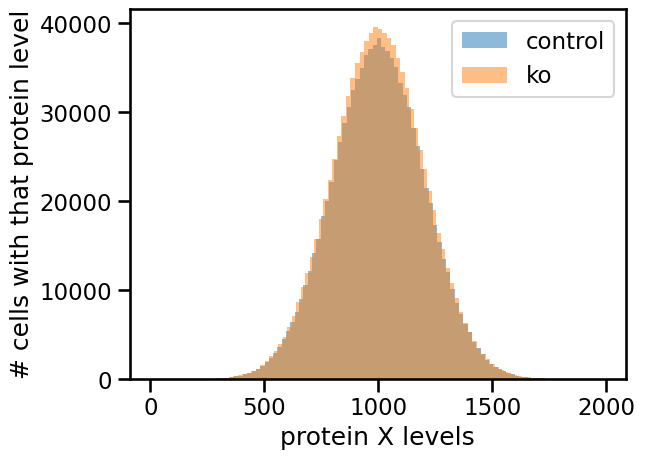

In [ ]:
control_mu = 1000
control_sigma = 200
computed_points = 1000000

ko_mu = 1000
ko_sigma = 200

control_proteinX_levels = np.random.normal(control_mu,control_sigma,computed_points)
ko_proteinX_levels = np.random.normal(ko_mu,ko_sigma,computed_points)
hist_plot(control_proteinX_levels, ko_proteinX_levels)

In [ ]:
def do_an_experiment(underlying_distribution, number_replicates):
    return np.random.choice(underlying_distribution, number_replicates, replace=True)

the p-value for this test was: 0.007492969524424978


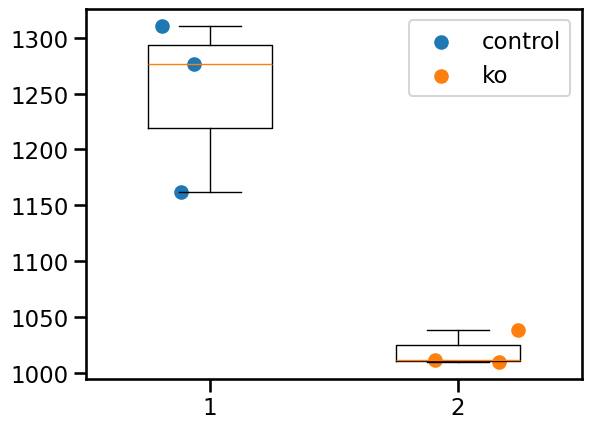

In [ ]:
control_measurements = do_an_experiment(control_proteinX_levels, 3) #Do an experiment on you control cells
ko_measurements = do_an_experiment(ko_proteinX_levels, 3) #Do an experiment on you KO cells
jigger_plot([control_measurements, ko_measurements], ['control', 'ko']) #Plot your data
a = ttest_ind(control_measurements, ko_measurements) #Perform the appropriate 2-sample t-test
print('the p-value for this test was: '+str(a[1]))

Did anyone in the class get a "significant" result?

### Key question
* Given the real distributions we've defined, how often do you expect to randomly get a p-value of 0.05?

Back to the board

## 2 | Type II errors and statistical power
* How do we think about circumstances when the null hypothesis is wrong, but we fail to reject it?

* Let's start with a new perturbation that has a real (albeit small) effect

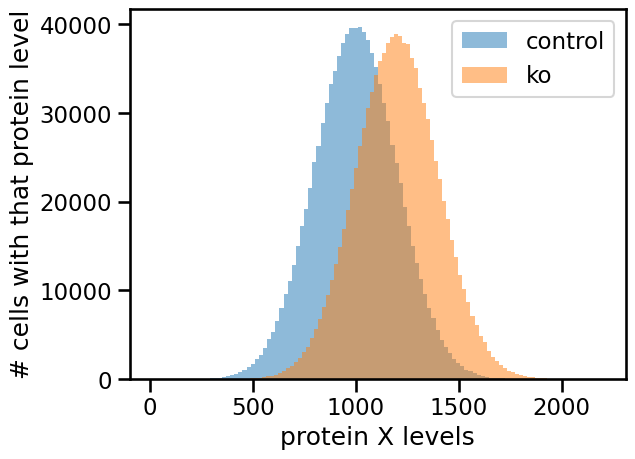

In [ ]:
control_mu = 1000
control_sigma = 200

ko_mu = 1200
ko_sigma = 200

control_proteinX_levels = np.random.normal(control_mu,control_sigma,computed_points)
ko_proteinX_levels = np.random.normal(ko_mu,ko_sigma,computed_points)
hist_plot(control_proteinX_levels, ko_proteinX_levels)

We can again run our simulation 1000 times, and using the calc_p_values_list function we defined last time, generate a list of 1000 p-values

In [ ]:
def calc_p_values_list(null_hypothesis_distribution, alternative_hypothesis_distribution, replicates, num_simulations):
    p_values = []
    for sim in range(num_simulations):
        control_measurements = do_an_experiment(null_hypothesis_distribution, replicates)
        ko_measurements = do_an_experiment(alternative_hypothesis_distribution, replicates)
        p_values.append(round(ttest_ind(control_measurements, ko_measurements)[1],3))
    return np.array(p_values)

In [ ]:
replicates = 3
num_simulations=1000
all_p_values = calc_p_values_list(control_proteinX_levels, ko_proteinX_levels,
                                  replicates=replicates, num_simulations=num_simulations)
all_p_values.sort()
print('--top values--')
print(all_p_values[0:100]) #show the first 100 p-values
print('--bottom values--')
print(all_p_values[-100:]) #show the last 100 p-values

--top values--
[0.    0.    0.    0.    0.001 0.001 0.001 0.001 0.002 0.002 0.002 0.002
 0.003 0.003 0.003 0.004 0.004 0.004 0.004 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.006 0.006 0.006 0.006 0.007 0.007 0.007 0.007 0.007 0.008
 0.008 0.009 0.009 0.009 0.009 0.01  0.01  0.01  0.011 0.011 0.012 0.012
 0.012 0.012 0.013 0.013 0.014 0.014 0.014 0.014 0.015 0.015 0.015 0.015
 0.016 0.016 0.016 0.016 0.017 0.017 0.017 0.018 0.018 0.018 0.018 0.018
 0.018 0.019 0.019 0.019 0.02  0.02  0.02  0.02  0.02  0.021 0.021 0.021
 0.021 0.021 0.021 0.022 0.022 0.023 0.024 0.024 0.024 0.024 0.025 0.026
 0.026 0.026 0.027 0.028]
--bottom values--
[0.799 0.801 0.806 0.807 0.807 0.81  0.811 0.817 0.82  0.822 0.823 0.823
 0.824 0.824 0.828 0.829 0.83  0.838 0.839 0.842 0.844 0.85  0.85  0.852
 0.86  0.86  0.86  0.861 0.863 0.863 0.864 0.865 0.871 0.873 0.873 0.874
 0.875 0.876 0.876 0.877 0.878 0.88  0.881 0.882 0.882 0.883 0.886 0.887
 0.887 0.888 0.888 0.89  0.892 0.894 0.894 0.896 0.898 0.9   0.90

Let's now calculate the number of false-negatives at each p-value cuttoff (alpha) we might use

In [ ]:
print('alpha\tfalse_negatives')
for alpha in np.arange(0, 0.2, 0.01):
    type_II_errors = all_p_values[all_p_values>alpha].shape[0]
    print(str(alpha)+'\t'+str(type_II_errors))

alpha	false_negatives
0.0	996
0.01	956
0.02	919
0.03	892
0.04	866
0.05	836
0.06	813
0.07	780
0.08	755
0.09	726
0.1	711
0.11	695
0.12	671
0.13	651
0.14	632
0.15	614
0.16	600
0.17	586
0.18	576
0.19	558


* Clearly there is a trade-off between your rate of Type I (false positive) and Type II (false negative) errors

* Given our simulation, we can plot this trade-off. To make this more general, let's calculate the "fraction of type II errors" at each alpha, which is just our number of type II errors/number of simulations. We'll call this value beta

In [ ]:
alphas = np.arange(0,1,0.01)

In [ ]:
betas = np.array([all_p_values[all_p_values>alpha].shape[0]/num_simulations for alpha in alphas])

Text(0, 0.5, 'beta')

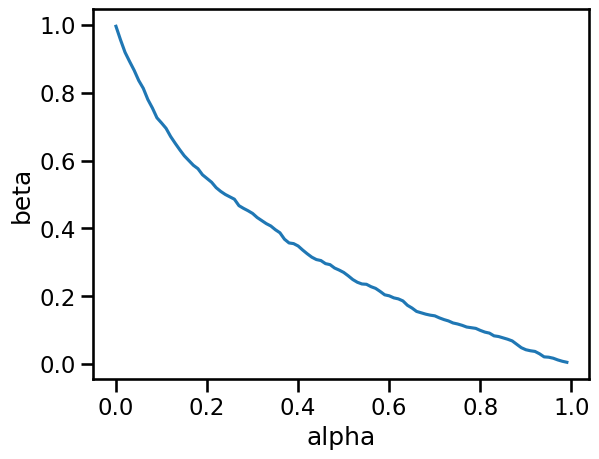

In [ ]:
plt.plot(alphas, betas)
plt.xlabel('alpha')
plt.ylabel('beta')

### Key point
* As we become more likely to make Type I errors (false positives), we become less likely to make Type II errors (false negatives).

### Statistical power of a designed study
* Often, it's important to understand if our proposed study has the "power" to likely reject the null hypothesis if an effect of an expected size is present.
  * Think about why this is important in our work.

* "Power" is just the probability that we reject the null hypothesis given that the null hypothesis is false. That's simply 1-beta.

Let's write a function to capture everything we've been doing and dig into thinking about "power"

In [ ]:
def calc_power_vs_alpha(null_distribution, alt_distribution,
                        replicates, num_simulations, v_line=0.05):

    all_p_values = np.array([ttest_ind(do_an_experiment(null_distribution, replicates),
                                       do_an_experiment(alt_distribution, replicates))[1] for i in range(num_simulations)])

    alphas = np.arange(0,0.5,0.01)

    betas = np.array([all_p_values[all_p_values>alpha].shape[0]/num_simulations for alpha in alphas])
    plt.plot(alphas, 1-betas)
    plt.axvline(x=v_line, color='red')
    plt.xlabel('alpha')
    plt.ylabel('power [1-beta]')
    plt.title('number of replicates in experiment: '+ str(replicates))
    return [alphas, 1-betas]

What parameters do we expect to affect power?

Let's simulate some distributions and see

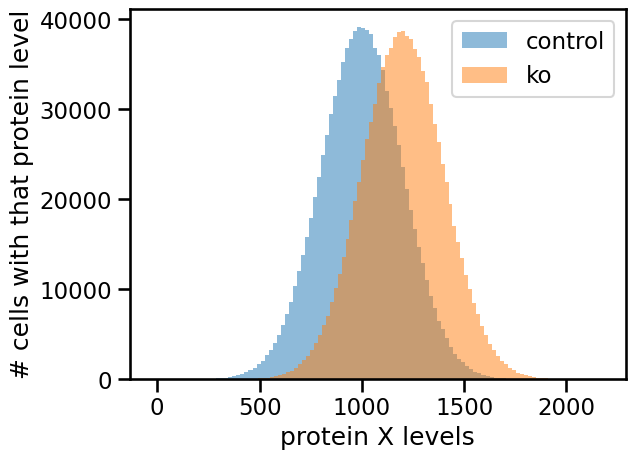

In [ ]:
control_mu = 1000
control_sigma = 200

ko_mu = 1200
ko_sigma = 200

control_proteinX_levels = np.random.normal(control_mu,control_sigma,computed_points)
ko_proteinX_levels = np.random.normal(ko_mu,ko_sigma,computed_points)

hist_plot(control_proteinX_levels, ko_proteinX_levels)

Given a fixed significance cuttoff (0.01), let's explore how our number of replicates affects our study's power

[]

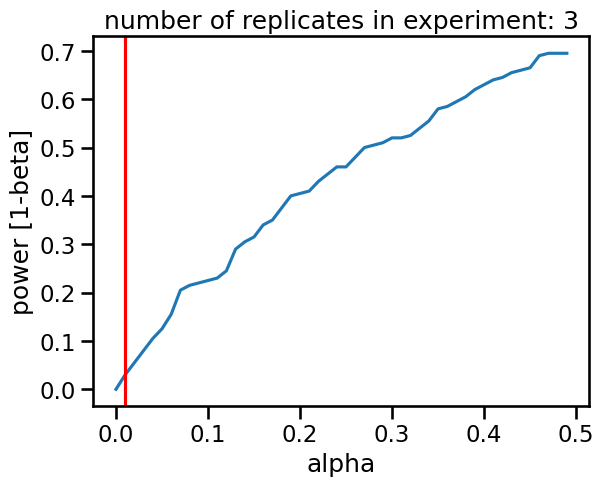

In [ ]:
calc_power_vs_alpha(control_proteinX_levels, ko_proteinX_levels,
                        replicates=3, num_simulations=200,  v_line=0.01)
plt.plot()

[]

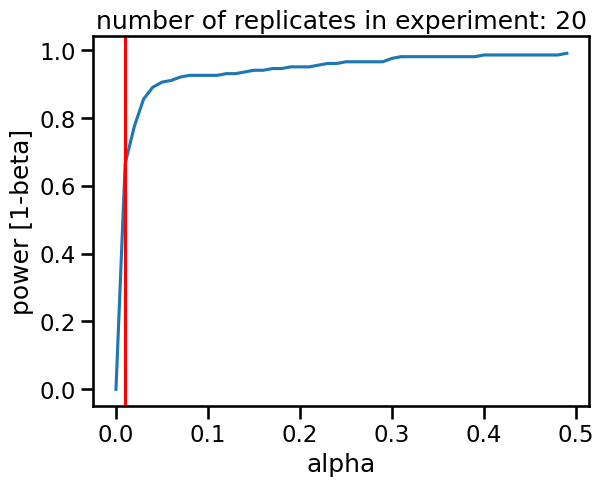

In [ ]:
calc_power_vs_alpha(control_proteinX_levels, ko_proteinX_levels,
                        replicates=20, num_simulations=200, v_line=0.01)
plt.plot()

At a fixed alpha, we can plot this relationship

In [ ]:
def calc_power_vs_sample(null_distribution, alt_distribution, fixed_alpha,
                         study_size_range, num_simulations, h_line=0.8):
    power_array = []
    for study_size in study_size_range:
        all_p_values = np.array([ttest_ind(do_an_experiment(null_distribution, study_size),
                                           do_an_experiment(alt_distribution, study_size))[1] for i in range(num_simulations)])
        beta = all_p_values[all_p_values>fixed_alpha].shape[0]/num_simulations
        power_array.append(1-beta)

    plt.plot(study_size_range, power_array)
    plt.scatter(study_size_range, power_array, marker='x', s=100, color='black')
    plt.xlabel('study_size')
    plt.ylabel('power [1-beta]')
    plt.axhline(y=h_line, color='red')
    return [study_size_range,np.array(power_array)]

In [ ]:
study_size_range = [2,4,8,16,32,64,128]

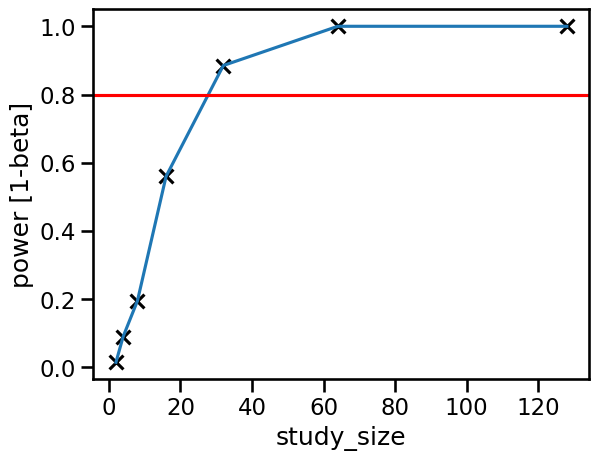

In [ ]:
alpha, power = calc_power_vs_sample(control_proteinX_levels, ko_proteinX_levels, 0.01, study_size_range, 200)

* How many samples should we do to have an 80% chance of seeing our underlying effect?

### Key points
* Study power is a function of alpha (significance cutoff), sample size (number of replicates), and ???
* Given any of the above 3 items, we can simulate or analytically calculate the remaining variable.
* One should ALWAYS work through these considerations BEFORE starting your experiment - it makes you state your assumptions and determine if you're doing an experiment that will be useful!
